In [93]:
import hashlib
import os
import tarfile
import zipfile
import requests

# @save
DATA_HUB= dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [94]:
def download(name, cache_dir='/Users/admin/Datasets'):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok = True)  # 创建目录，如果已存在，不报错
    # fname 文件名
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):  # 如果文件已存在，检查是否发生变化
        sha1 = hashlib.sha1()  # sha1 加密对象
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576) # 一次读1M
                if not data:
                    break
                sha1.update(data)  # 间断计算
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存，
    print(f"正在从{url}下载{fname}...")
    # verify 检查证书, stream 默认情况下false，会立即下载并保存在内存中。倘若文件过大就会导致内存不足的情况。
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)  # 写入文件
    return fname

In [95]:
def download_extract(name, folder=None):
    """下载解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    # data_dir, .csv
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')  # 创建对象
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [96]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [97]:
import os
os.path.splitext('/Users/admin/Datasets/2.txt')

('/Users/admin/Datasets/2', '.txt')

In [98]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [99]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [100]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [101]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [102]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc
                          [:, 1:]))

In [103]:
# 数据预处理

In [104]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [105]:
# "dummy_na=True" 将 "na"（缺失值）视为有效特征值
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [106]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [137]:
train_features.shape

torch.Size([1460, 331])

In [252]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 128),
                        nn.Dropout(0.2),
                        nn.ReLU(),
                        nn.Linear(128, 1))
    return net

In [108]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_pred = torch.clamp(net(features), 1, float('inf'))  # float('inf')  # 正负无穷
    rmse = torch.sqrt(loss(torch.log(clipped_pred),
                           torch.log(labels)))
    return rmse.item()

In [118]:
# Adam优化器对初始学习率不那么敏感
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)
    # optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [110]:
# 使用K折交叉验证
"""
    K折交叉验证，它有助于模型选择和超参数调整。我们首先需要定义一个函数，在K折交叉验证过程中返回第i折的数据。具体地说，它选择第i个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。
"""

'\n    K折交叉验证，它有助于模型选择和超参数调整。我们首先需要定义一个函数，在K折交叉验证过程中返回第i折的数据。具体地说，它选择第i个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。\n'

In [111]:
def get_k_fold_data(k, i, X, y):
    """
  首先，将全部样本划分为k个大小相等的样本子集
  依次遍历这k个子集，每次把当前子集作为验证集，其余所有样本作为训练集，进行模型的训练和评估。
  最后把k次评估指标的平均值作为最终的评估指标
    """
    assert k > 1
    fold_size = X.shape[0] // k   # 一个样本子集的大小
    valid_idx = slice(i*fold_size, (i+1)*fold_size)
    X_valid, y_valid = X[valid_idx, :], y[valid_idx]
    if i == 0:
        X_train, y_train = X[(i+1)*fold_size:, :], y[(i+1)*fold_size:]
    else:
        X_train = torch.cat([X[0:(i*fold_size), :], X[(i+1)*fold_size:,:]], 0)
        y_train = torch.cat([y[0:(i*fold_size)], y[(i+1)*fold_size:]], 0)

    # X_train, y_train = None, None
    # for j in range(k):
    #     idx = slice(j * fold_size, (j + 1) * fold_size)
    #     X_part, y_part = X[idx, :], y[idx]  # 取测试集
    #     if j == i:
    #         X_valid, y_valid = X_part, y_part  # 第一轮，直接赋值
    #     elif X_train is None:
    #         X_train, y_train = X_part, y_part
    #     else:
    #         X_train = torch.cat([X_train, X_part], 0)
    #         y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [112]:
a = torch.arange(4).reshape(2, 2)
b = torch.arange(4, 8).reshape(2, 2)

In [113]:
data = get_k_fold_data(5, 0, train_features, train_labels)

In [114]:
a, b, c, d = data

In [115]:
a

tensor([[-0.1679, -0.3986,  0.1573,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0673,  0.0000,  0.8230,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.4581, -0.0720,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.3025, -0.1416, -0.1428,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735, -0.0559, -0.0572,  ...,  1.0000,  0.0000,  0.0000],
        [-0.8735,  0.2439, -0.0293,  ...,  1.0000,  0.0000,  0.0000]])

In [116]:
# 当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):  # 训练k次
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i+1}, 训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1, 训练log rmse0.097733, 验证log rmse0.156343
折2, 训练log rmse0.106924, 验证log rmse0.123138
折3, 训练log rmse0.100708, 验证log rmse0.143761
折4, 训练log rmse0.100098, 验证log rmse0.167937
折5, 训练log rmse0.094585, 验证log rmse0.157060
折6, 训练log rmse0.097783, 验证log rmse0.126262
折7, 训练log rmse0.105921, 验证log rmse0.148373
折8, 训练log rmse0.104451, 验证log rmse0.133022
折9, 训练log rmse0.097674, 验证log rmse0.160423
折10, 训练log rmse0.097870, 验证log rmse0.142114
10-折验证：平均训练log rmse: 0.100375,平均验证log rmse: 0.145843


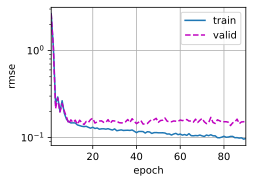

In [276]:
k, num_epochs, lr, weight_decay, batch_size = 10, 90, 0.2, 40, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse: {float(train_l):f},'
      f'平均验证log rmse: {float(valid_l):f}')

In [264]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epoch, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epoch, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.096358


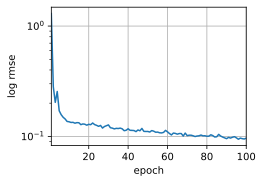

In [315]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 0.38, 10, 128
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)